# Python On Resonance (PyOR)
## Everybody can simulate NMR

Author: Vineeth Thalakottoor 

Email: vineethfrancis.physics@gmail.com

## Tutorial 5: Evolution of Density Matrix in Hilbert Space Part 2
In previous tutorial, we try to evolve the density matrix in time by solving Liouville-Von Neumann equation in Hilbert Space for a single spin half system. In this tutorial we will see two spin half system with out coupling.

## Load Python packages and define path to the source file "PythonOnResonance.py"

In [1]:
pathSource = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_beta/Source'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append(pathSource)

import PythonOnResonance as PyOR

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib notebook
import sympy as sp
from sympy import *

## Generating Spin System

In [3]:
"""
Define Spin quantum numbers of your spins in "Slist1".
Slist1[0] is spin of first particle and Slist1[1] is spin of second particle.
""";

Slist1 = [1/2,1/2]

In [4]:
"""
Define Planck constant equals 1. 
Because NMR spectroscopists are more interested to write Energy in frequency units. 
if False then hbarEQ1 = hbar
""";

hbarEQ1 = True

In [5]:
"""
Generate Spin Operators
""";

System = PyOR.Numerical_MR(Slist1,hbarEQ1)

"""
Sx, Sy and Sz Operators
""";
Sx,Sy,Sz = System.SpinOperator()

"""
S+ and S- Operators
""";
Sp,Sm = System.PMoperators(Sx,Sy)

## Zeeman Hamiltonian in Lab Frame

In [6]:
"""
Gyromagnetic Ratio
Gamma = [Gyromagnetic Ratio spin 1, Gyromagnetic Ratio spin 1, ...]
""";
Gamma = [System.gammaH1,System.gammaH1]

"""
Define the field of the spectromter, B0 in Tesla.
"""
B0 = 9.4

"""
Define the chemical Shift of individual spins
Offset = [chemical Shift spin 1, chemical Shift spin 1, ..]
"""
Offset = [20,40] # Offset frequency in Hz

"""
Function "LarmorF" give the list Larmor frequencies of individual spins in lab frame
"""
LarmorF = System.LarmorFrequency(Gamma,B0,Offset)

Hz = System.Zeeman(LarmorF,Sz)

Larmor Frequency in MHz:  [-400.22803765 -400.22805765]


## Initialize Density Matrix

In [7]:
"""
We will generate Initial Density Matrix in two ways: 
First we will generate a density matrix as we prefer say, Sz. 
Second we will create density matrix at thermal equlibrium

First Case
""";

Thermal_DensMatrix = False 

if Thermal_DensMatrix:
    Hz_EnUnit = System.Convert_FreqUnitsTOEnergy(Hz)
    HT_approx = False # High Temperature Approximation is False
    T = 300 # Temperature in Kelvin
    rho_in = System.EqulibriumDensityMatrix(Hz_EnUnit,T,HT_approx)
    rhoeq = rho_in.copy()   
else:
    rho_in = np.sum(Sz,axis=0) # Initial Density Matrix
    rhoeq = np.sum(Sz,axis=0)  # Equlibrium Density Matrix   
    print("Trace of density metrix = ", np.trace(rho_in))

Trace of density metrix =  0j


In [8]:
Matrix(rho_in)

Matrix([
[1.0, 0, 0,    0],
[  0, 0, 0,    0],
[  0, 0, 0,    0],
[  0, 0, 0, -1.0]])

<IPython.core.display.Javascript object>


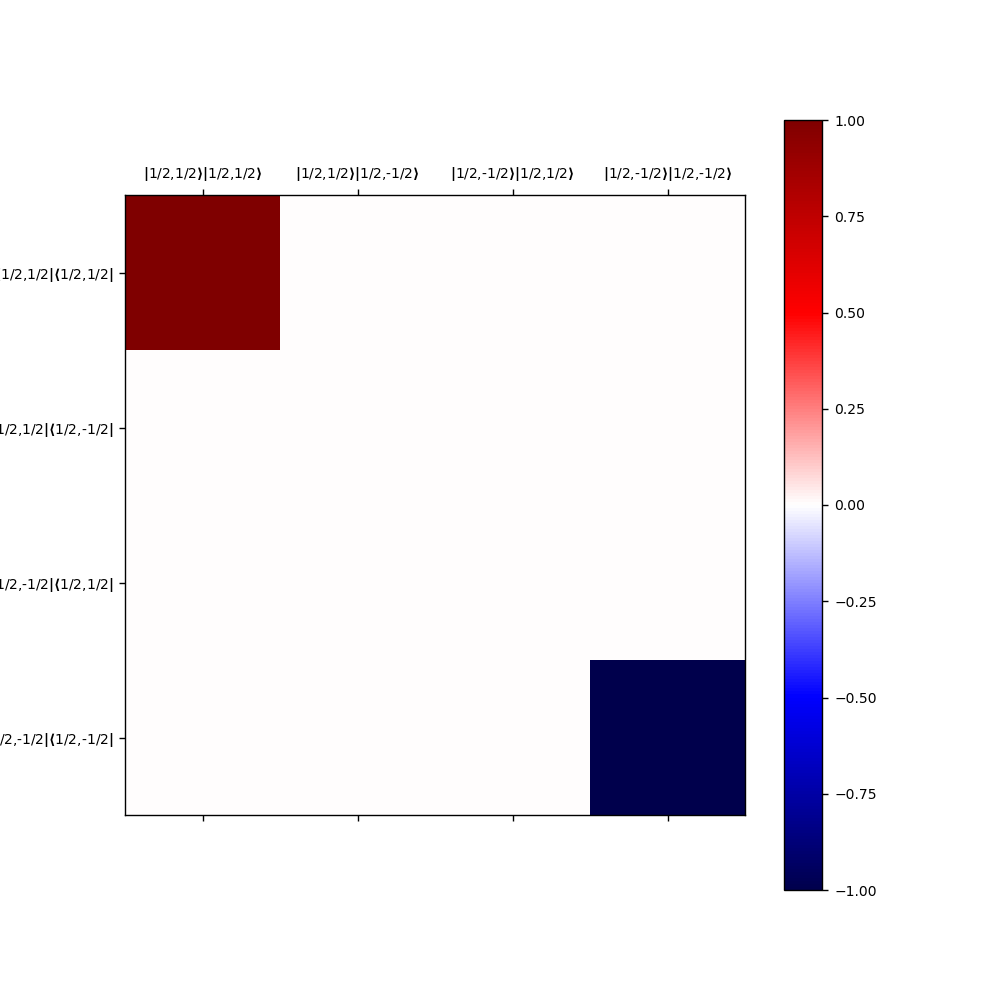

In [9]:
System.MatrixPlot(1,rho_in.real)

## Zeeman Halitonian in Rotating Frame

In [10]:
OmegaRF = [-System.gammaH1*B0,-System.gammaH1*B0]
Hzr = System.Zeeman_RotFrame(LarmorF, Sz, OmegaRF)

## Pulse

In [11]:
"""
Rotate the magnetization about Y-axis, by an angle theta.
""";
pulse_angle = 90.0
rho = System.Rotate_H(rho_in,pulse_angle,np.sum(Sy,axis=0)) 

<IPython.core.display.Javascript object>


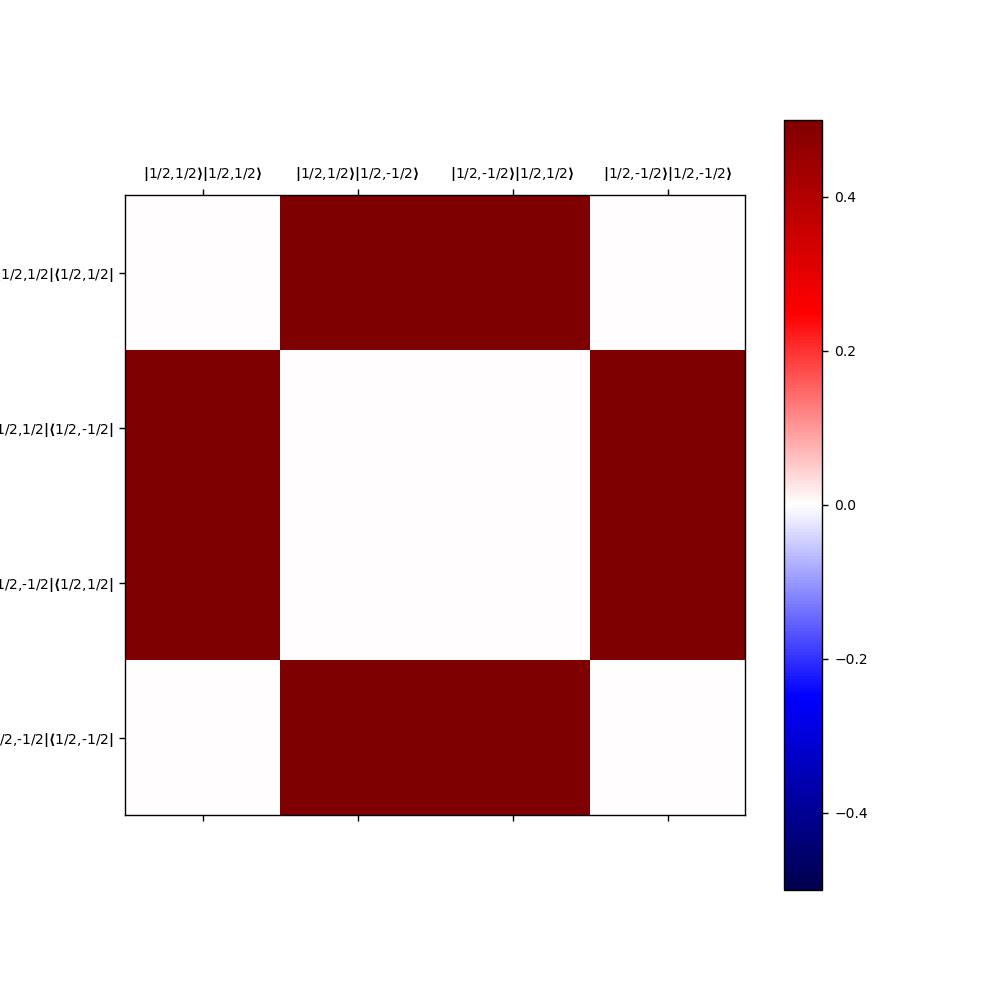

In [12]:
System.MatrixPlot(2,rho.real)

## Relaxation Constant

In [13]:
'''
Define longitudinal (R1) and transverse Relaxation (R2)
''';

R1 = 0
R2 = 0
System.Relaxation_Constants(R1,R2)

'''
Options for "Rprocess": "No Relaxation" 
                         or "Phenomenological" 
                         or "Auto-correlated Random Field Fluctuation"
                         or "Auto-correlated Dipolar Heteronuclear"
                         or "Auto-correlated Dipolar Homonuclear"
''';
Rprocess = "No Relaxation"

## Evolution of Density Matrix

In [14]:
"""
Samplling Rate, fs = n * Highest_Larmor_Frequency; minimum value of n = 2 (Nyquist–Shannon sampling theorem)
Dwell time, dt = 1/fs
Acquisition time, AQ is time for which we evolve the density matrix, in seconds.
Number of points in the simulation, Npoints
""";
Highest_Larmor_Frequency = 40.0
fs = 4 * Highest_Larmor_Frequency
dt = 1.0/fs
AQ = 5.0
Npoints = int(AQ/dt)
print("Number of points in the simulation", Npoints)

"""
option for solver, "method": "Unitary Propagator" or "ODE Solver"
"""
method = "Unitary Propagator"

start_time = time.time()
t, rho_t = System.Evolution_H(rhoeq,rho,Sx,Sy,Sz,Sp,Sm,Hzr,dt,Npoints,method,Rprocess)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Number of points in the simulation 800
Total time = 0.013356208801269531 seconds 


## Expectation value

In [15]:
"""
Basis Operators in plus minus Z 
""";
Basis = "PMZ spin half"
B_PMZ, dic = System.TwoSpinOP(Sx,Sy,Sz,Sp,Sm,Basis)
print("dic: ",dic)

dic:  ['E', 'S+', 'S-', 'Sz', 'I+', 'I-', 'Iz', 'S+ Iz', 'S- Iz', 'Sz I+', 'Sz I-', 'Sz Iz', 'S+ I+', 'S+ I-', 'S- I+', 'S- I-']


In [16]:
"""
Lets see the expectation value of I+ and S+
""";

t, Mp = System.Expectation_H(rho_t,B_PMZ[1] + B_PMZ[4],dt,Npoints)

## Windowing

In [17]:
Mp = System.WindowFunction(t,Mp,5.0)

## Fourier Transform

In [18]:
fs = 1.0/dt
freq, spectrum = System.FourierTransform(Mp,fs,5)

## Plotting

<IPython.core.display.Javascript object>


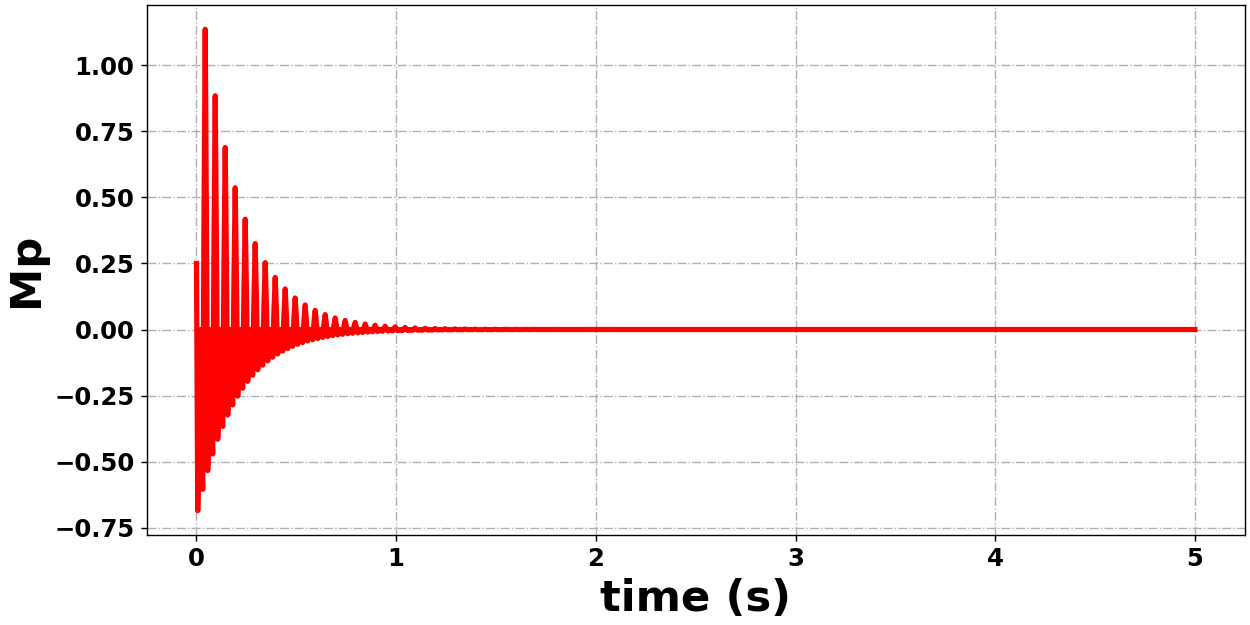

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [19]:
System.Plotting(3,t,Mp,"time (s)","Mp","red")

<IPython.core.display.Javascript object>


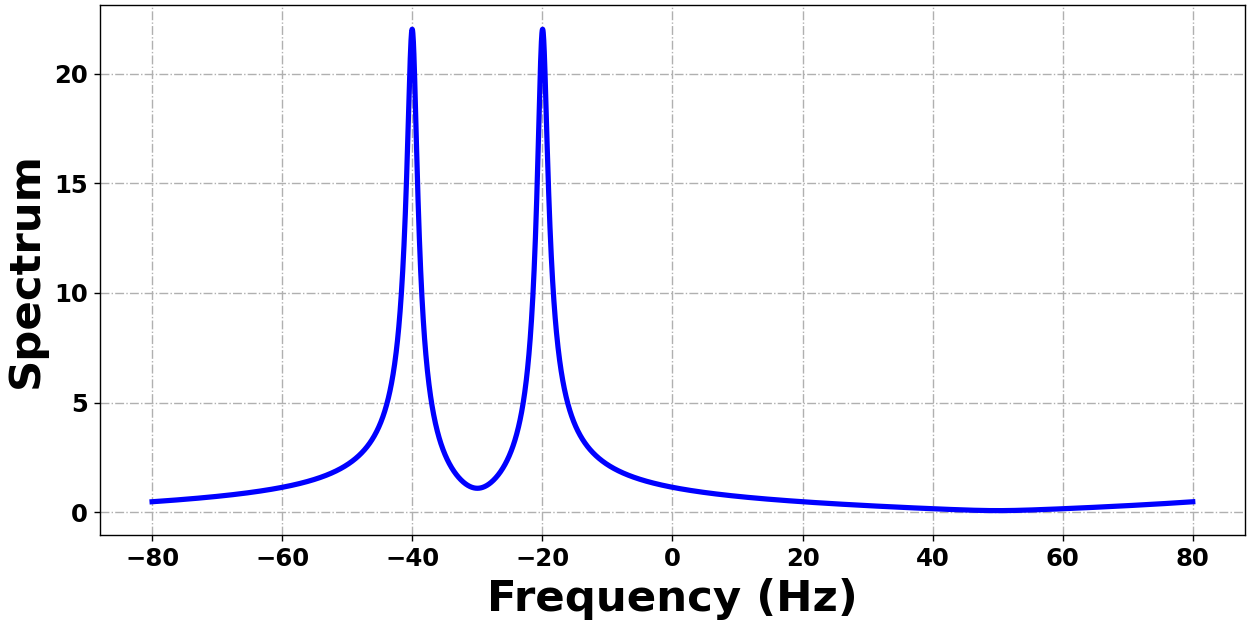

No handles with labels found to put in legend.


In [20]:
System.Plotting(4,freq,np.absolute(spectrum),"Frequency (Hz)","Spectrum","blue")

## Any suggestion? write to me
If you see something is wrong please write to me, so that the PyOR can be error free. 

vineethfrancis.physics@gmail.com